2024-12-24 07:50:42,647 - INFO - Initializing Data Loaders
2024-12-24 07:50:42,690 - INFO - Data Loaders initialized successfully
2024-12-24 07:50:42,697 - INFO - Starting training
2024-12-24 07:50:43,590 - INFO - Epoch 1/10, Loss: 71.5509
2024-12-24 07:50:43,982 - INFO - Epoch 2/10, Loss: 22.7086
2024-12-24 07:50:44,776 - INFO - Epoch 3/10, Loss: 14.7327
2024-12-24 07:50:45,344 - INFO - Epoch 4/10, Loss: 10.9493
2024-12-24 07:50:45,789 - INFO - Epoch 5/10, Loss: 7.7819
2024-12-24 07:50:46,227 - INFO - Epoch 6/10, Loss: 6.0279
2024-12-24 07:50:46,657 - INFO - Epoch 7/10, Loss: 5.5602
2024-12-24 07:50:47,057 - INFO - Epoch 8/10, Loss: 3.2265
2024-12-24 07:50:47,469 - INFO - Epoch 9/10, Loss: 2.3092
2024-12-24 07:50:47,880 - INFO - Epoch 10/10, Loss: 1.3835
2024-12-24 07:50:47,880 - INFO - Training completed
2024-12-24 07:50:47,881 - INFO - Starting evaluation
2024-12-24 07:50:48,043 - INFO - Evaluation completed with Accuracy: 93.92%
2024-12-24 07:50:48,044 - INFO - Visualizing predicti

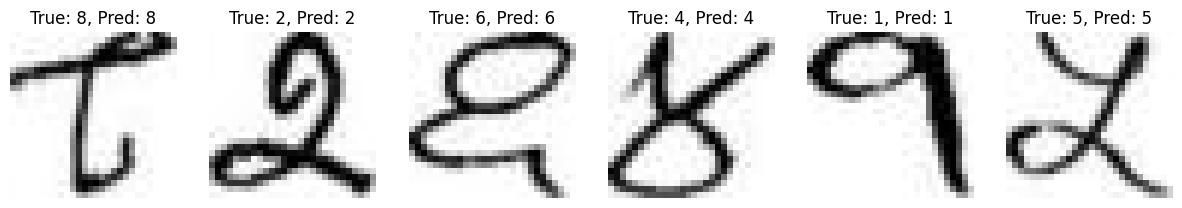

In [1]:
# Classical Neural Network for Nepali MNIST Classification
import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt

# Setting up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define Dataset Class
class NepaliMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path):  # Ensure only files are processed
                    self.data.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Paths
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"

def initialize_data_loaders(root_dir, batch_size=32):
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    logger.info("Data Loaders initialized successfully")
    return train_loader, test_loader

# Define the Model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, optimizer, loss_fn, epochs):
    logger.info("Starting training")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.float()
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        logger.info(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    logger.info("Training completed")

def evaluate_model(model, test_loader):
    logger.info("Starting evaluation")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.float()
            labels = labels.long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    logger.info(f"Evaluation completed with Accuracy: {accuracy:.2f}%")
    return accuracy

def visualize_predictions(model, test_loader):
    logger.info("Visualizing predictions")
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.float()
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].numpy().squeeze(), cmap='gray')
        ax.set_title(f"True: {labels[idx]}, Pred: {predictions[idx]}")
        ax.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR)

    model = NeuralNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_model(model, train_loader, optimizer, loss_fn, epochs=10)
    accuracy = evaluate_model(model, test_loader)
    visualize_predictions(model, test_loader)
